In [1]:
import json
import time

import requests
import hashlib
import json
import base64

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from test_single_img import load_model_and_label, pred_single, label_dict, pred_text

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微软雅黑
mpl.rcParams['font.serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题,或者转换负号为字符串

In [3]:
CAPTCHA_GET_URL = "https://kyfw.12306.cn/passport/captcha/captcha-image?login_site=E&module=login&rand=sjrand"
CAPTCHA_CHK_URL = "https://kyfw.12306.cn/passport/captcha/captcha-check"

request_headers = {
    "Accept": "text/javascript, application/javascript, application/ecmascript, application/x-ecmascript, */*; q=0.01",
    "Accept-Encoding": "gzip, deflate, br",
    "Accept-Language": "zh-CN,zh;q=0.9,en-GB;q=0.8,en;q=0.7",
    "Connection": "keep-alive",
    "Host": "kyfw.12306.cn",
    "Referer": "https://kyfw.12306.cn/otn/resources/login.html",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "same-origi",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.75 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest"
}

In [4]:
session = requests.session()
session.headers = request_headers

def gen_imgs(img):
    interval = 6
    length = 66
    for x in range(41, img.shape[0] - length, interval + length):
        for y in range(interval, img.shape[1] - length, interval + length):
            yield img[x:x + length, y:y + length]

load_model_and_label()

image recognition model: h5/20210314-02/ResNetV2-97.h5
text recognition model: h5/20210411-text01/checkpoint-50.h5


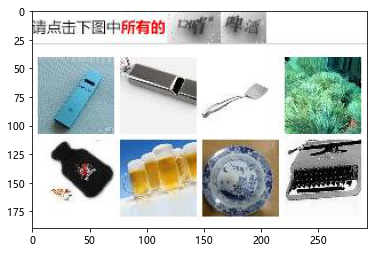

In [15]:
timestamp = int(round(time.time()*1000))
response = session.get(CAPTCHA_GET_URL + f'&{timestamp}')
captcha = response.content

bytestream = np.array(bytearray(captcha))
img = cv2.imdecode(bytestream, cv2.IMREAD_COLOR)
plt.imshow(img[:, :, ::-1])

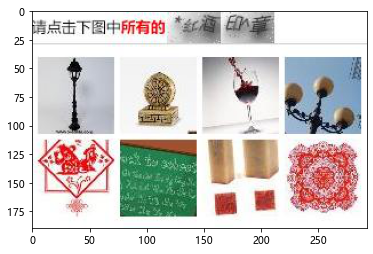

In [21]:
img = cv2.imread('net/bootstrap_failed/1618224688-cdae8617c2898636689f91c212b71599.png')

plt.imshow(img[:, :, ::-1])

红酒0.9892, 红枣0.0025, 雨靴0.0020, 高压锅0.0019, 话梅0.0006, 
印章0.9917, 耳塞0.0023, 开瓶器0.0018, 刺绣0.0007, 雨靴0.0007, 
[1, 6]


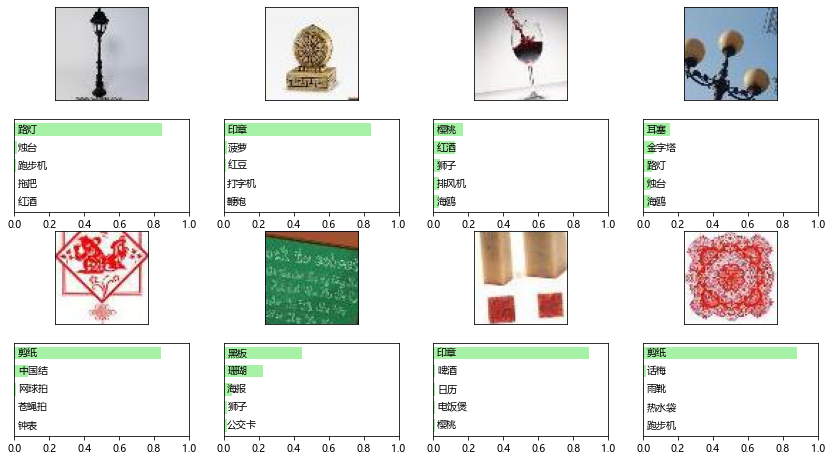

In [22]:
top_k = 5
wanna_saved = None

selected_index = []

text_prediction = pred_text(img)
text_indexes = []

for i in range(text_prediction.shape[0]):
    index_list = np.argpartition(text_prediction[i], -top_k)[-top_k:]
    index_list = sorted(index_list, key=lambda x: -text_prediction[i, x].numpy())
    for idx in index_list:
        print("%s%.4f"%(label_dict[idx], text_prediction[i, idx]), end=', ')
    text_indexes.append(index_list[0])
    print("")

plt.figure(figsize=(14.4, 12))
label_np = np.array(label_dict)
for i, image in enumerate(gen_imgs(img)):
    if i == 2:
        wanna_saved = image
    prediction = pred_single(image)
    blk = 8 * (i//4) + (i%4) + 1
    
    index_list = np.argpartition(prediction, -top_k)[-top_k:]
    index_list = sorted(index_list, key=lambda x: -prediction[x].numpy())
    if index_list[0] in text_indexes:
        selected_index.append(i)
    
    plt.subplot(6, 4, blk)
    plt.imshow(image[:,:,::-1]/255)
    plt.yticks([])
    plt.xticks([])
    
    plt.subplot(6, 4, blk+4)
    b = plt.barh(range(top_k), prediction.numpy()[index_list][::-1], height=0.7, color='lightgreen', alpha=0.8)
    labels = label_np[index_list][::-1]
    for cnt, rect in enumerate(b):
        plt.text(0.02, rect.get_y()+rect.get_height()/2, labels[cnt], ha='left', va='center')
    plt.yticks([])
    plt.xlim(0,1)
print(selected_index)

In [17]:
indices = {0: "48,70",
           1: "100,70",
           2: "180,70",
           3: "250,70",
           4: "48,150",
           5: "100,150",
           6: "180,150",
           7: "250,150"}
ans = ','.join([indices[i] for i in selected_index])
print(ans)


paras = {
    "answer":ans, 
    "rand": "sjrand",
    "login_site": "E"
}

response = session.get(CAPTCHA_CHK_URL, params=paras)
print(response.text)

48,70,100,70,100,150
{"result_message":"验证码校验成功","result_code":"4"}


In [14]:
cv2.imwrite('archive/13/manual_0028.png', wanna_saved)

True

**注：以下是试验**

'bf209f316cc714c09b786da483eca2c5'

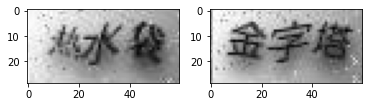

In [24]:
imgs = extract_text_img(img)
if len(imgs) == 1:
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[0], cmap='gray')
else:
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[0], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(imgs[1], cmap='gray')

import hashlib
m = hashlib.md5()
for val in imgs[0]:
    m.update(val)
m.hexdigest()

In [20]:
def extract_text_img(img):
    text_img = img[:29, 117:250]
    text_img = cv2.cvtColor(text_img, cv2.COLOR_BGR2GRAY)
    
    text_img2 = cv2.GaussianBlur(text_img, (3,3), 1)
    sobelY = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ])
    edges = cv2.filter2D(text_img2, -1, sobelY)
    _, thres = cv2.threshold(edges, 0, 1, cv2.THRESH_OTSU)
    
    col_sum = np.sum(thres, axis=0)
    divides = np.argwhere(col_sum > 27).squeeze()
    imgs = []
    
    if len(divides) < 2:
        _, thres = cv2.threshold(text_img, 0, 1, cv2.THRESH_OTSU)
        col_sum = np.sum(thres, axis=0)
        divides = np.argwhere(col_sum < 26)
        right = np.max(divides) + 12
        imgs.append(text_img[:, :right])
    else:
        last_num = 2
        cnt = 0
        sums = 0
        ans = []
        for num in divides:
            if num == last_num + 1:
                sums += num
                cnt += 1
            else:
                if cnt > 0:
                    ans.append(int(round(sums / cnt)))
                sums = num
                cnt = 1
            last_num = num
        ans.append(int(round(sums / cnt)))
        
        imgs.append(text_img[:, :ans[0]].copy())
        imgs.append(text_img[:, ans[0]:ans[1]].copy())
        # assert len(ans) == 2
    return imgs

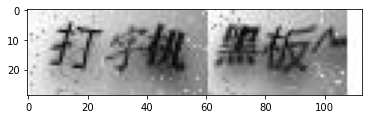

In [70]:
text_img = img[:29, 117:230]
text_img = cv2.cvtColor(text_img, cv2.COLOR_BGR2GRAY)
plt.imshow(text_img, cmap='gray')

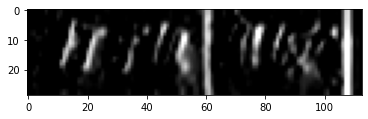

In [71]:
text_img2 = cv2.GaussianBlur(text_img, (3,3), 1)
sobelY = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])
edges = cv2.filter2D(text_img2, -1, sobelY)
plt.imshow(edges, cmap='gray')

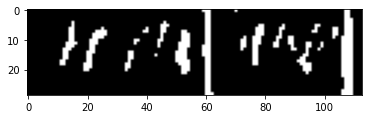

In [72]:
_, thres = cv2.threshold(edges, 0, 1, cv2.THRESH_OTSU)
plt.imshow(thres, cmap='gray')

In [75]:
col_sum = np.sum(thres, axis=0)
divides = np.argwhere(col_sum > 27).squeeze()
print(divides)
last_num = 2
cnt = 0
sums = 0
ans = []
for num in divides:
    if num == last_num + 1:
        sums += num
        cnt += 1
    else:
        if cnt > 0:
            ans.append(int(round(sums / cnt)))
        sums = num
        cnt = 1
    last_num = num
ans.append(int(round(sums / cnt)))

# assert len(ans) == 2
print(ans)

[ 60  61 107 108]
[60, 108]


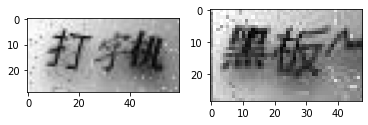

In [74]:
img1 = text_img[:, :ans[0]].copy()
img2 = text_img[:, ans[0]:ans[1]].copy()

plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')